# Part 3, Topic 3: DPA on Firmware Implementation of AES

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, you saw how a single bit of information can be used to recover an entire byte of the AES key. Remember, this works due to the S-Box being present in the data flow that we are attacking.*

*Next, we'll see how to use power analysis instead of an actual bit value. With this technique, the goal is to separate the traces by a bit in the result of the SBox output (it doesn't matter which one): if that bit is 1, its group of traces should, on average, have higher power consumption during the SBox operation than the other set.*

*This is all based on the assumption we discussed in the slides and saw in earlier labs: there is some consistent relationship between the value of bits on the data bus and the power consumption in the device.*

**LEARNING OUTCOMES:**

* Using a power measurement to 'validate' a possible device model.
* Detecting the value of a single bit using power measurement.
* Breaking AES using the classic DPA attack.


## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).
* ☑ Breaking AES Using a Single Bit (we'll build on your previous work).

## AES Model

No need to remember the complex model from before - we can instead just jump right into the AES model! Copy your AES model you developed in the previous lab below & run it:

In [1]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]
# ###################
# END SOLUTION
# ###################

You can verify the model works by running the following blocks, just like last time:

In [2]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


## AES Power Watcher

The next step is to send random data to the device, and observe the power consumption during the encryption.

The idea is that we will use a capture loop like this:

    print(scope)
    for i in trange(N, desc='Capturing traces'):
        key, text = ktp.next()  # manual creation of a key, text pair can be substituted here

        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace)
        plot.send(trace)

    #Convert traces to numpy arrays
    trace_array = np.asarray([trace.wave for trace in traces])
    textin_array = np.asarray([trace.textin for trace in traces])
    known_keys = np.asarray([trace.key for trace in traces])  # for fixed key, these keys are all the same

Depending what you are using, you can complete this either by:

* Capturing new traces from a physical device.
* Reading pre-recorded data from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!

In [3]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='MASKEDAES'
SS_VER='SS_VER_1_1'
CRYPTO_OPTIONS='ANSSI+UNROLLED+KEYSCHEDULE'

In [4]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


INFO: Found ChipWhisperer😍


In [5]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$CRYPTO_OPTIONS" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 CRYPTO_OPTIONS=$3 SS_VER=$4

Building for platform CWLITEARM with CRYPTO_TARGET=MASKEDAES
SS_VER set to SS_VER_1_1
Impletementation=ANSSI
Options=UNROLLED KEYSCHEDULE
make clean_objs .dep 
make[1]: Entering directory '/home/daniel/Documents/Uni/Semester 2/Crypt/Assignment2/ChipWhisperer/hardware/victims/firmware/simpleserial-aes'
Building for platform CWLITEARM with CRYPTO_TARGET=MASKEDAES
SS_VER set to SS_VER_1_1
Impletementation=ANSSI
Options=UNROLLED KEYSCHEDULE
rm -f -- simpleserial-aes-CWLITEARM.hex
rm -f -- simpleserial-aes-CWLITEARM.eep
rm -f -- simpleserial-aes-CWLITEARM.cof
rm -f -- simpleserial-aes-CWLITEARM.elf
rm -f -- simpleserial-aes-CWLITEARM.map
rm -f -- simpleserial-aes-CWLITEARM.sym
rm -f -- simpleserial-aes-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s aes-independant.s platform.s aes.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32

.
Compiling C: aes.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -mthumb-interwork -fno-builtin -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DMASKEDAES -DANSSI_CM4 -DUSE_KEIL_PLATFORM -DUSE_FULL_UNROLLING -DTRIG_BEFORE_KS -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CWLITEARM/aes.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto/ -I.././crypto/SecAESSTM32/src -I.././crypto/SecAESSTM32/src/aes -I.././crypto/SecAESSTM32/src/printf -std=gnu99  -MMD -MP -MF .dep/aes.o.d aes.c -o objdir-CWLITEARM/aes.o
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4

In [6]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 11527 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 11527 bytes


In [25]:
#
# Perform the capture, resulting in trace_array and textin_array of 2500 traces.
#

from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 25000
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

assert(len(trace_array) == 25000)
print("✔️ OK to continue!")

/tmp/ipykernel_16178/3331628377.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/25000 [00:00<?, ?it/s]

✔️ OK to continue!


What's this data look like? Try plotting a trace or two here:

<IPython.core.display.Javascript object>


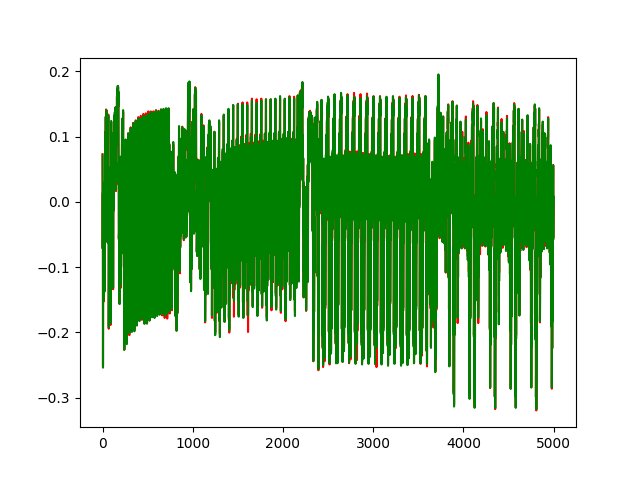

In [26]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure()
plt.plot(trace_array[0], 'r')
plt.plot(trace_array[1], 'g')
plt.show()

OK interesting - so we've got data! And what about the format of the input data?

In [27]:
print(textin_array[0])
print(textin_array[1])

CWbytearray(b'32 b4 2b 4d c8 e8 97 86 1e ca b5 6d 0b 31 cd a6')
CWbytearray(b'd5 2b 14 4c 5e 17 16 8b e8 39 f9 ff dc d4 ee 0f')


## AES Guesser - One Byte

The attack now needs a way of splitting traces into two groups, depending on the state of a bit in our "guessed" value. We're going to start easy by guessing a single byte of the AES key at a time.

To start with - define the number of traces & number of points in each trace. You can use the following example code, just run this block:

In [28]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

If you remember from the slides - our algorithm looks like this:    

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:
        
        one_list = empty list
        zero_list = empty list
        
        for trace_index in [0, 1, 2, 3, ..., numtraces]:
        
            input_byte = textin_array[trace_index][byte_to_attack]
            
            #Get a hypothetical leakage list - use aes_internal(guess, input_byte)          

            if hypothetical_leakage bit 0 is 1:
                append trace_array[trace_index] to one_list
            else:
                append trace_array[trace_index] to zero_list
                
        one_avg = average of one_list
        zero_avg = average of zero_list

        max_diff_value = maximum of ABS(one_avg - zero_avg)
        
To get the average of your `one_list` and `zero_list` you can use numpy:

    import numpy as np
    avg_one_list = np.asarray(one_list).mean(axis=0)

The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

To help you do some testing - let me tell you that the correct value of byte 0 is `0x2B`. You can use this to validate that your solution is working on the first byte. If you get stuck - see some hints below (but give it a try first).

What you should see is an output of the maximum value between the two average groups be higher for the `0x2B` value. For example, priting the maximum SAD value from an example loop looks like this for me:

    Guessing 28: 0.001397
    Guessing 29: 0.000927
    Guessing 2a: 0.001953
    Guessing 2b: 0.005278
    Guessing 2c: 0.000919
    Guessing 2d: 0.002510
    Guessing 2e: 0.001241
    Guessing 2f: 0.001242

Note the value of `0.005278` for `0x2B` - this is higher than the others which range from `0.000927` to `0.002510`.

In [29]:
# ###################
# Add your code here
# ###################
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        
        #Get a hypothetical leakage list - use aes_internal(guess, input_byte)
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])
    
        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:        
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])
            
    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))
    
    print("Guessing %02x: %f"%(guess, mean_diffs[guess]))

Guessing 00: 0.000244
Guessing 01: 0.000237
Guessing 02: 0.000341
Guessing 03: 0.000193
Guessing 04: 0.000318
Guessing 05: 0.000249
Guessing 06: 0.000309
Guessing 07: 0.000389
Guessing 08: 0.000290
Guessing 09: 0.000178
Guessing 0a: 0.000222
Guessing 0b: 0.000309
Guessing 0c: 0.000309
Guessing 0d: 0.000226
Guessing 0e: 0.000345
Guessing 0f: 0.000275
Guessing 10: 0.000251
Guessing 11: 0.000204
Guessing 12: 0.000414
Guessing 13: 0.000227
Guessing 14: 0.000297
Guessing 15: 0.000224
Guessing 16: 0.000374
Guessing 17: 0.000379
Guessing 18: 0.000284
Guessing 19: 0.000283
Guessing 1a: 0.000297
Guessing 1b: 0.000332
Guessing 1c: 0.000218
Guessing 1d: 0.000242
Guessing 1e: 0.000280
Guessing 1f: 0.000268
Guessing 20: 0.000251
Guessing 21: 0.000306
Guessing 22: 0.000279
Guessing 23: 0.000285
Guessing 24: 0.000191
Guessing 25: 0.000368
Guessing 26: 0.000362
Guessing 27: 0.000380
Guessing 28: 0.000221
Guessing 29: 0.000261
Guessing 2a: 0.000299
Guessing 2b: 0.000329
Guessing 2c: 0.000208
Guessing 2

### Hint 1: General Program Flow

You can use the following general program flow to help you implement the outer loop above:

In [ ]:
#Hint #1 - General Program Flow
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        #Inside here do the steps shown above
        pass
        
    #Do extra steps to average one_list and zero_list        

### Hint 2: Example of Two Different Key Guesses

We aren't fully going to give it away (see `SOLN` notebook if you want that), but here is how you can generate two differences, for `0x2B` and `0xFF`. If you're totally stuck you can use the following code to base what should be inside the loops on.

In [21]:
import numpy as np
mean_diffs = np.zeros(256)

### Code to do guess of byte 0 set to 0x2B
guessed_byte = 0
guess = 0x2B
   
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_2b = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0x2B: {:1}".format(mean_diffs_2b))

### Code to do guess of byte 0 set to 0xFF
guessed_byte = 0
guess = 0xFF
    
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_ff = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0xFF: {:1}".format(mean_diffs_ff))

Max SAD for 0x2B: 0.0007698567427083247
Max SAD for 0xFF: 0.0006957908188779116


## Ranking Guesses

You'll also want to rank some of your guesses (we assume). This will help you identify the most likely value. The best way to do this is build a list of the maximum difference values for each key:

    mean_diffs = [0]*256

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:

        *** CODE FROM BEFORE***
        max_diff_value = maximum of ABS(one_avg - zero_avg)
        mean_diffs[key_byte_guess_value] = max_diff_value
        
If you modify your previous code, it will generate a list of maximum differences in a list. This list will look like:

    [0.002921, 0.001923, 0.005131, ..., 0.000984]
    
Where the *index* of the list is the value of the key guess. We can use `np.argsort` which generates a new list showing the *indicies* that would sort an original list (you should have learned about `argsort` in the previous lab too):

So for example, run the following to see it in action on the list `[1.0, 0.2, 3.4, 0.01]`:

In [20]:
np.argsort([1.0, 0.2, 3.4, 0.01])

array([3, 1, 0, 2])

This should return `[3, 1, 0, 2`] - that is the order of lowest to highest. To change from highest to lowest, remember you just add `[::-1]` at the end of it like `np.argsort([1.0, 0.2, 3.4, 0.01])[::-1]`.

Try using the `np.argsort` function to output the most likely key values from your attack.

In [18]:
sotred_list = np.argsort(mean_diffs)

## Plotting Differences

Before we move on - you should take a look at various plots of these differences. They will play in something called the *ghost peak* problem.

We're going to now define a function called `calculate_diffs()` that implements our attacks (you can replace this with your own function or keep this one for now):

In [30]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

Try plotting the difference between various bytes. For byte 0, remember `0x2B` is the correct value. Zoom in on the plots and see how the correct key should have a much larger difference.

Sometimes we get *ghost peaks* which are incorrect peaks. So far we're assuming there is a single "best" solution for the key - we may need to get fancy and put a threshold whereby we have several candidates for the correct key. For now let's just plot a handful of examples:

<IPython.core.display.Javascript object>


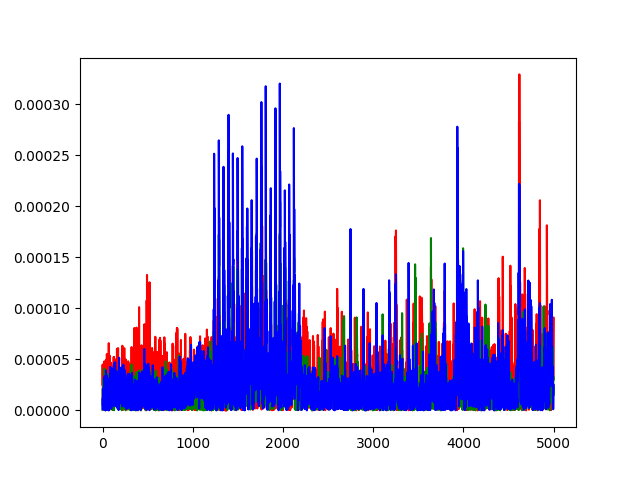

In [31]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(calculate_diffs(0x2B), 'r')
plt.plot(calculate_diffs(0x2C), 'g')
plt.plot(calculate_diffs(0x2D), 'b')

Here is what it should look like:

You'll notice when we rank the bytes we just use the maximum value of any peak. There's lots more you could learn from these graphs, such as the location of the peak, or if there are multiple peaks in the graph. But for now we're just going to keep with the 

## AES Guesser - All Bytes

Alright - good job! You've got a single byte and some DPA plots up. Now let's move onward and guess *all* of the bytes.

Doing this requires a little more effort than before. Taking your existing guessing function, you're going to wrap a larger loop around the outside of it like this:

    for subkey in range(0,16):
        #Rest of code from before!
        

In [32]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    # ###################
    # Add your code here
    # ###################
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    sorted_args = np.argsort(max_diffs)[::-1]
    
    key_guess.append(sorted_args[0])

    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))

    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")


/tmp/ipykernel_16178/2943055148.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely E4 (actual 2B)
 Top 5 guesses: 
   E4 - Diff = 0.000546
   B7 - Diff = 0.000528
   84 - Diff = 0.000489
   50 - Diff = 0.000444
   72 - Diff = 0.000440


Subkey  1 - most likely CC (actual 7E)
 Top 5 guesses: 
   CC - Diff = 0.000522
   7D - Diff = 0.000496
   49 - Diff = 0.000433
   45 - Diff = 0.000432
   0E - Diff = 0.000423


Subkey  2 - most likely 4E (actual 15)
 Top 5 guesses: 
   4E - Diff = 0.000633
   FC - Diff = 0.000555
   4D - Diff = 0.000553
   B5 - Diff = 0.000550
   C7 - Diff = 0.000514


Subkey  3 - most likely 3A (actual 16)
 Top 5 guesses: 
   3A - Diff = 0.000464
   49 - Diff = 0.000449
   36 - Diff = 0.000449
   C5 - Diff = 0.000448
   EE - Diff = 0.000441


Subkey  4 - most likely 99 (actual 28)
 Top 5 guesses: 
   99 - Diff = 0.000637
   A5 - Diff = 0.000445
   9E - Diff = 0.000444
   45 - Diff = 0.000423
   54 - Diff = 0.000420


Subkey  5 - most likely 40 (actual AE)
 Top 5 guesses: 
   40 - Diff = 0.000495
   BE - Diff = 0.000483
   39 

🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳
Congrats - you did it!!!!

Hopefully the above worked - but we're going to go a little further to understand how to apply this in case it didn't work right away (or it almost worked).

## Ghost Peaks

Maybe the previous didn't actually recover the full key? No need to worry - there are a few reasons for this. One artifact of a DPA attack is you get another strong peak that isn't the correct key (which can be a ghost peak).

We're going to get into more efficient attacks later, but for now, let's look at some solutions:

* Increase the number of traces recorded.
* Change the targetted bit (& combine solutions from multiple bits).
* Window the input data.

The first one is the brute-force option: go from 2500 to 5000 or even 10000 power traces. As you add more data, you may find the problem is reduced. But real ghost peaks may not disappear, so we need to move onto other solutions.

Before we begin - we're going to give you a "known good" DPA attack script we're going to build on. This uses the `calculate_diffs()` function defined earlier.

Run the following block (will take a bit of time):

In [33]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    
    max_diffs = [0]*256
    full_diffs = [0]*256

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
    
    #Make copy of the list
    full_diffs_list.append(full_diffs[:])
    
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

/tmp/ipykernel_16178/1918268658.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely E4 (actual 2B)
 Top 5 guesses: 
   E4 - Diff = 0.000546
   B7 - Diff = 0.000528
   84 - Diff = 0.000489
   50 - Diff = 0.000444
   72 - Diff = 0.000440


Subkey  1 - most likely CC (actual 7E)
 Top 5 guesses: 
   CC - Diff = 0.000522
   7D - Diff = 0.000496
   49 - Diff = 0.000433
   45 - Diff = 0.000432
   0E - Diff = 0.000423


Subkey  2 - most likely 4E (actual 15)
 Top 5 guesses: 
   4E - Diff = 0.000633
   FC - Diff = 0.000555
   4D - Diff = 0.000553
   B5 - Diff = 0.000550
   C7 - Diff = 0.000514


Subkey  3 - most likely 3A (actual 16)
 Top 5 guesses: 
   3A - Diff = 0.000464
   49 - Diff = 0.000449
   36 - Diff = 0.000449
   C5 - Diff = 0.000448
   EE - Diff = 0.000441


Subkey  4 - most likely 99 (actual 28)
 Top 5 guesses: 
   99 - Diff = 0.000637
   A5 - Diff = 0.000445
   9E - Diff = 0.000444
   45 - Diff = 0.000423
   54 - Diff = 0.000420


Subkey  5 - most likely 40 (actual AE)
 Top 5 guesses: 
   40 - Diff = 0.000495
   BE - Diff = 0.000483
   39 

This block should now print some *next top guesses* - in this case just the next top 5 guesses, but you can extend this if you wish. It's also keeping a copy of all the *difference* traces (unlike before where it threw them away).

### Plotting Peaks

After it runs, select a subkey that is either wrong or has very close "next best guesses". For example, the following shows the output for Subkey 5 is actually wrong - the correct guess (`0xAE`) has been ranked as option 5.

    Subkey  5 - most likely CB (actual AE)
     Top 5 guesses: 
       CB - Diff = 0.003006
       C5 - Diff = 0.002984
       AE - Diff = 0.002739
       3C - Diff = 0.002674
       2F - Diff = 0.002511

You can find the full diff in the `full_diffs_list` array. If you index this array it will give you every guess for a given subkey (for example `full_diffs_list[5]` is the 5th subkey guess outputs).

Using `full_diffs_list[N]` to get your selected subkey, plot the correct key by plotting `full_diffs_list[N][0xCORRECT]` in green as the *last* (so it appears on top). Plot a few other highly ranked guesses before that. In my example, this would look like:

    %matplotlib notebook
    import matplotlib.pylab as plt

    plt.plot(full_diffs_list[5][0xC5], 'r')
    plt.plot(full_diffs_list[5][0xCB], 'r')
    plt.plot(full_diffs_list[5][0xAE], 'g')

<IPython.core.display.Javascript object>


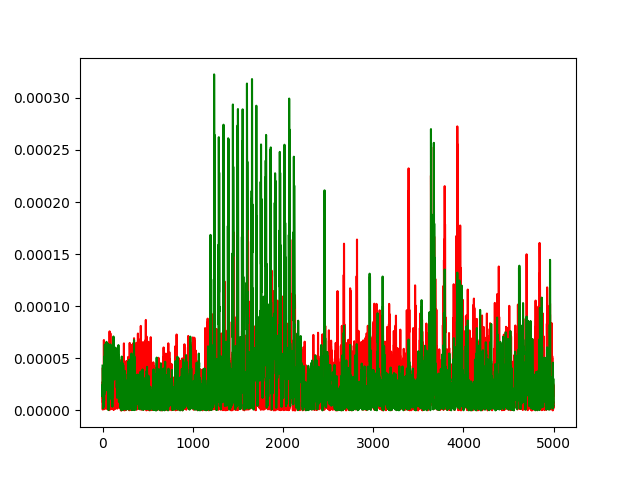

In [34]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(full_diffs_list[5][0xC5], 'r')
plt.plot(full_diffs_list[5][0xCB], 'r')
plt.plot(full_diffs_list[5][0xAE], 'g')

Zoom in on the window, and you should notice there is a location where the correct peak is *higher* than the incorrect peaks. If you want to plot all the traces (this will get slow!) for a given trace, we can do so as the following:

<IPython.core.display.Javascript object>


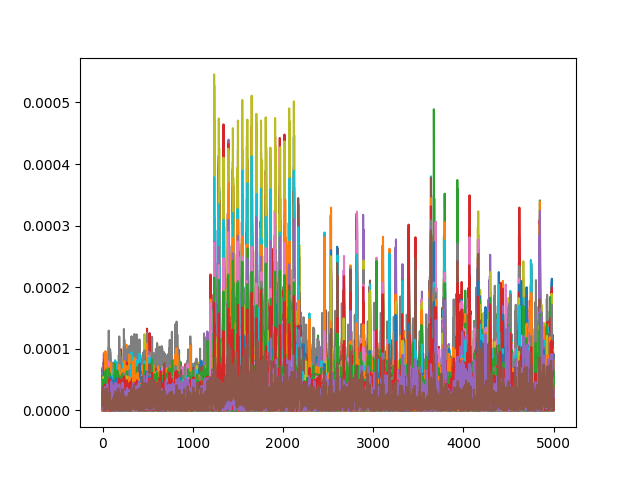

In [35]:
plt.figure()
subkey = 0
for guess in range(0, 256):
    plt.plot(full_diffs_list[subkey][guess])
plt.show()

Depending on your hardware, the previous may show a single nice large spike, or multiple large spikes. If we have the ghost peak problem you've probably got multiple spikes. The incorrect peaks may trail behind the correct locations -- we can first plot the correct locations by looking at the known key. The following will do that:

<IPython.core.display.Javascript object>


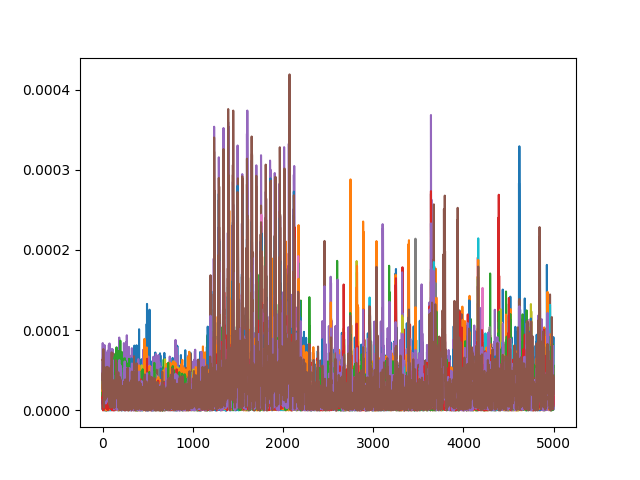

In [36]:
plt.figure()
for subkey in range(0, 16):
    plt.plot(full_diffs_list[subkey][known_key[subkey]])
plt.show()

### Windowing Peaks

The final trick here - see if there is some way to "window" the data that could be useful. For example, looking at the peaks you might notice that the correct peaks are always coming at 60 cycle offsets, with the first peak around sample 1100 (these will be different for your hardware).

So we could modify the loop to only look at differences after this point:

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        full_diff_trace = full_diff_trace[(1010 + subkey*60):]
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
Copy the full DPA attack here - and try it out! See if you can get the correct key to come out for every byte.

In [37]:
# ###################
# Add your code here
# ###################

from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add Your Code Here")
    
    # ###################
    # START SOLUTION
    # ###################
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        full_diff_trace = full_diff_trace[(1010 + subkey*60):]
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

/tmp/ipykernel_16178/3888310629.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely E4 (actual 2B)
 Top 5 guesses: 
   E4 - Diff = 0.000546
   B7 - Diff = 0.000528
   84 - Diff = 0.000489
   50 - Diff = 0.000444
   72 - Diff = 0.000440




KeyboardInterrupt: 

### Attacking Other Bits

So far we only looked at bit 0 $-$ but there are more bits involved here! You can first just try another bit that might be present, maybe they simply work better?

But you can also combine multiple bits by creating a most likely solution that applies across *all* bits.

The first one is easy to try out, as we defined the bit to attack in the previous script

The second option is a little more advanced. You can give it a try $-$ but in practice, if you are trying to combine multiple bits, a more effective method called the CPA attack will be used.

## Conclusions & Next Steps

You've now seen how a DPA attack be be performed using a basic Python script. We'll experience much more effective attacks once we look at the CPA attack.

If you want to perform these attacks in practice, the Python code here isn't the most efficient! We'll look at faster options in later courses.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>